In [12]:
## importing all libraries for our models

# Keras' Multiclass DeepLabV3+ tutorial: https://keras.io/examples/vision/deeplabv3_plus/
# convert NumPy array to PNG: https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/
# VGG Image Annotator (for manual mask generation): https://www.robots.ox.ac.uk/~vgg/software/via/

import os
import cv2
from scipy.io import loadmat


# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc
from keras.layers.advanced_activations import LeakyReLU

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [2]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    wind_speeds = []

    for path in paths:
        wind_speeds = np.append(wind_speeds, float(path['maxwind']))

    highest_wind = max(wind_speeds)
    
    print (hurricane, 'max wind ', get_max_wind)
    return highest_wind

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    print (precips, " precips: ", temperatures)
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 200, 200)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    print (sst, " temperatures: ", temperatures)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 200, 200)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    print (colors, " rgbs: ", temperatures)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :200, :200]
    rgb_array = rgb_array.reshape(1, 48, 200, 200)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/noaa_sst_*.npy'

    sst = glob.glob(file, recursive = True)
    sst.sort()
    sst = sst[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, sst[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    
def createWindMap(profile):
    # return nparray(1, 200, 200)
    # hurricane center is  at (99,99),   each direction expand by 100 miles
    
    res = np.zeros((200, 200))
    
    maxwindradius = min(int(float(profile['maxwindradius'])), 99)
    maxwind = float(profile['maxwind'])
    
    keys = []
    for it in profile.keys():
        if 'kt' in it:
            keys.append(it)        
    keys.sort()
    
    for it in keys:
        if "ne" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100 +j] = max(0, float(it[:-4]))
        elif "se" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100 +j] = max(0, float(it[:-4]))
        elif "nw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100-j-1] = max(0, float(it[:-4]))
        elif "sw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100-j-1] = max(0, float(it[:-4]))
                        
    for i in range(-maxwindradius, maxwindradius):
        for j in range(-maxwindradius, maxwindradius):
            res[99 + i, 99 + j] = maxwind
    
    res = np.expand_dims(res, axis = 0)
                    
    return res

In [11]:
def getCategory(wind_speed): # based on the Saffir-Simpson Scale for hurricane classification
    
    thresholds = [('TD', 33), ('TS', 63), ('Category_1', 82), ('Category_2', 95), ('Category_3', 112), ('Category_4', 136)]
    
    for it in thresholds:
        if wind_speed <= it[1]:
            return it[0]
    return thresholds[-1][0]

def selectDay(cat_dictionary):
    pick_days = []
    for key in cat_dictionary.keys():
        pick_days = np.append(pick_days, cat_dictionary[key][0])
    return pick_days

def getStageByDay(folder, day):
    
    imerg_names = folder + '/imerg_precipitation_' + day + '_*.npy'
    sst_names = folder + '/noaa_sst_' + day + '*.npy'
    rgb_names = folder + '/10_wavelet_rgb_' + day + '*.npy'
    #rgb_names = folder + '/10_modis_satellite_' + day + '*.npy'
    
    profile_name = folder + '/profile.json'
    f = open(profile_name)
    profile = json.load(f)
    paths = profile['path']

    imergs = glob.glob(imerg_names, recursive = True)
    ssts = glob.glob(sst_names, recursive = True)
    rgbs = glob.glob(rgb_names, recursive = True)
    
    imerg_array = np.zeros((200, 200))
    for imerg in imergs:
        im_arr = np.load(imerg)
        print(imerg, len(im_arr.flatten()))
        if not (sizeCheck(im_arr)):
            continue
        imerg_array = imerg_array + np.load(imerg)

    imerg_array = imerg_array.reshape(1, 200, 200)
    imerg_array = imerg_array / len(imergs)
    
    if (not rgbs) or (not ssts):
        #print("no rgbs or ssts: ", folder, day)
        return None
    
    
    sst_array = np.load(ssts[0])
    print(sst_array.shape, folder)
    
    if (not sizeCheck(sst_array)) or (not sizeCheck(imerg_array)):      
        #print("sst shape invalid: ", folder, day)
        return None

    rgb_array = np.load(rgbs[0])
    rgb_array = rgb_array[:, :200, :200]
    #rgb_array = rgb_array[100:300, 100:300, :]
    rgb_array = ((rgb_array * 10000 + 100) / 66.66)*1.5
    rgb_array = rgb_array.astype(int)

    rgb_array[rgb_array < 0] = 0
    rgb_array[rgb_array > 255] = 255
    print(rgb_array.shape)
        
        
    selected_days = []

    for path in paths:
        if path['date'] == int(day):
            selected_days.append(path)
        
    # pick mid element from path    
    middleIndex = int((len(selected_days) - 1)/2)
    if len(selected_days) == 2: 
        middleIndex = 1
        
    selected_day = selected_days[middleIndex]

    wind_array = createWindMap(selected_day)
    
    #stage_array = imerg_array
    #stage_array = np.append(stage_array, sst_array, axis = 0)
    
    stage_array = rgb_array
    
    #stage_array = np.append(stage_array, rgb_array, axis = 0)
    #stage_array = np.append(stage_array, wind_array, axis = 0)
    stage_array = np.expand_dims(stage_array, axis = 0)
    
    return stage_array

def sizeCheck(tensor): # size check should happen after stage data is collected
    shape = len(tensor.flatten())
    print(shape)
    if shape != 40000:
        return False
    else:
        return True
    
def populateStage(stage, step):
    if step is None:
        return stage
    if stage is None:
        stage = step
    else:
        stage = np.append(stage, step, axis = 0)
    return stage

In [4]:
def completeDataCollection(globname, max_wind_param): # NEW DATA COLLECTION METHOD - SORT INTO STAGES

    folders = glob.glob(globname, recursive = True)
    # AL032000, failed rgb glob (no modis satellite data for that day)
    # AL242005, failed ssts glob (no sst satellite data for that day)
    stage_1 = None
    stage_2 = None
    stage_3 = None
    highest_wind = None

    for folder in folders:
        print(type(stage_1))
        name = folder + '/profile.json'
        f = open(name)
        prof = json.load(f)
        paths = prof['path']

        cats = {} # dictionary with categories as keys, days as values.
        # used to extract day values based on hurricane category (stage)

        for path in paths:
            if int(path['maxwind']) < int(max_wind_param): # only select hurricanes with wind speed at least max_wind_param
                continue
            test = getCategory(int(path['maxwind']))

            if test not in cats.keys():
                cats[test] = []
            cats[test].append(str(path['date']))

        for key in cats.keys():
            cats[key] = list(set(cats[key]))
            cats[key].sort()

        days = selectDay(cats)
        print("category ", cats)
        print ("days:", days)
        if len(days) < 3:
            #print("not enough categories: ", folder)
            continue

        #print("valid folder: ", folder)


        step_1 = getStageByDay(folder, days[0])
        step_2 = getStageByDay(folder, days[1])
        step_3 = getStageByDay(folder, days[2])


        if (step_1 is None) or (step_2 is None) or (step_3 is None):
            #print("size not fit: ", folder)
            continue

        highest_wind = np.append(highest_wind, get_max_wind(folder))
        
        stage_1 = populateStage(stage_1, step_1)
        stage_2 = populateStage(stage_2, step_2)
        stage_3 = populateStage(stage_3, step_3)
        
        print("APPENDED", folder, " highest_wind", highest_wind)

        

    highest_wind = highest_wind[1:]
    print(stage_1.shape, stage_2.shape, stage_3.shape, highest_wind.shape)
    
    return stage_1, stage_2, stage_3, highest_wind


In [5]:
stage_1, stage_2, stage_3, highest_wind = completeDataCollection('/home/fun/data/AL*20*', 0)

<class 'NoneType'>
category  {'TD': ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809'], 'TS': ['20040809', '20040810', '20040811', '20040812']}
days: ['20040803' '20040809']
<class 'NoneType'>
category  {'TD': ['20040813', '20040820', '20040821', '20040822', '20040823', '20040824'], 'TS': ['20040814', '20040818', '20040819', '20040820'], 'Category_1': ['20040815', '20040818'], 'Category_2': ['20040815', '20040816', '20040817']}
days: ['20040813' '20040814' '20040815' '20040815']
/home/fun/data/AL042004/imerg_precipitation_20040813_1200.npy 40000
40000
/home/fun/data/AL042004/imerg_precipitation_20040813_1800.npy 40000
40000
(1, 200, 192) /home/fun/data/AL042004
38400
/home/fun/data/AL042004/imerg_precipitation_20040814_0000.npy 40000
40000
/home/fun/data/AL042004/imerg_precipitation_20040814_0600.npy 40000
40000
/home/fun/data/AL042004/imerg_precipitation_20040814_1200.npy 40000
40000
/home/fun/data/AL042004/imerg_precipitation_20040814_1800.npy 40000


(200, 200, 3)
/home/fun/data/AL112000/imerg_precipitation_20000916_0000.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000916_0600.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000916_1200.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000916_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL112000
40000
40000
(200, 200, 3)
/home/fun/data/AL112000/imerg_precipitation_20000917_0000.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000917_0600.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000917_1200.npy 40000
40000
/home/fun/data/AL112000/imerg_precipitation_20000917_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL112000
40000
40000
(200, 200, 3)
/home/fun/data/AL112000 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL112000  highest_wind [None 65.0 80.0 75.0 70.0 70.0]
<class 'numpy.ndarray'>
category  {'TD': ['20000915', '20000916', '20000917', '20000918', '20000919', '20000920

(200, 200, 3)
/home/fun/data/AL062001/imerg_precipitation_20010909_0000.npy 40000
40000
/home/fun/data/AL062001/imerg_precipitation_20010909_0600.npy 40000
40000
/home/fun/data/AL062001/imerg_precipitation_20010909_1800.npy 40000
40000
/home/fun/data/AL062001/imerg_precipitation_20010909_1200.npy 40000
40000
(1, 200, 200) /home/fun/data/AL062001
40000
40000
(200, 200, 3)
/home/fun/data/AL062001 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL062001  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0]
<class 'numpy.ndarray'>
category  {'TD': ['20010907', '20010908', '20010909', '20010910', '20010911', '20010918', '20010919'], 'TS': ['20010911', '20010912', '20010917', '20010918'], 'Category_1': ['20010913', '20010916', '20010917'], 'Category_2': ['20010913', '20010914', '20010915', '20010916'], 'Category_3': ['20010914']}
days: ['20010907' '20010911' '20010913' '20010913' '20010914']
/home/fun/data/AL072001/imerg_precipitation_20010907_1800.n

(1, 200, 200) /home/fun/data/AL172001
40000
40000
(200, 200, 3)
/home/fun/data/AL172001 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL172001  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0]
<class 'numpy.ndarray'>
category  {'TD': ['20020714', '20020715'], 'TS': ['20020715', '20020716', '20020717', '20020718', '20020719']}
days: ['20020714' '20020715']
<class 'numpy.ndarray'>
category  {'TD': ['20020804'], 'TS': ['20020805']}
days: ['20020804' '20020805']
<class 'numpy.ndarray'>
category  {'TD': ['20020805', '20020806'], 'TS': ['20020806', '20020807', '20020808']}
days: ['20020805' '20020806']
<class 'numpy.ndarray'>
category  {'TD': ['20020829', '20020904'], 'TS': ['20020829', '20020830', '20020831', '20020901', '20020902', '20020903', '20020904']}
days: ['20020829' '20020829']
<class 'numpy.ndarray'>
category  {'TD': ['20020901', '20020902'], 'TS': ['20020902', '20020903', '20020904', '20020905']}
da

(200, 200, 3)
/home/fun/data/AL052003/imerg_precipitation_20030718_0000.npy 40000
40000
/home/fun/data/AL052003/imerg_precipitation_20030718_0600.npy 40000
40000
/home/fun/data/AL052003/imerg_precipitation_20030718_1200.npy 40000
40000
/home/fun/data/AL052003/imerg_precipitation_20030718_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL052003
40000
40000
(200, 200, 3)
/home/fun/data/AL052003 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL052003  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0]
<class 'numpy.ndarray'>
category  {'TD': ['20030719', '20030720', '20030721']}
days: ['20030719']
<class 'numpy.ndarray'>
category  {'TD': ['20030725', '20030726']}
days: ['20030725']
<class 'numpy.ndarray'>
category  {'TS': ['20030814', '20030815', '20030816']}
days: ['20030814']
<class 'numpy.ndarray'>
category  {'TD': ['20030821', '20030822']}
days: ['20030821']
<class 'numpy.n

APPENDED /home/fun/data/AL012004  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0]
<class 'numpy.ndarray'>
category  {'TD': ['20040809', '20040810'], 'TS': ['20040810', '20040811'], 'Category_1': ['20040811', '20040812'], 'Category_2': ['20040812', '20040813'], 'Category_3': ['20040813'], 'Category_4': ['20040813']}
days: ['20040809' '20040810' '20040811' '20040812' '20040813' '20040813']
/home/fun/data/AL032004/imerg_precipitation_20040809_1200.npy 40000
40000
/home/fun/data/AL032004/imerg_precipitation_20040809_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL032004
40000
40000
(200, 200, 3)
/home/fun/data/AL032004/imerg_precipitation_20040810_0000.npy 40000
40000
/home/fun/data/AL032004/imerg_precipitation_20040810_0600.npy 40000
40000
/home/fun/data/AL032004/imerg_precipitation_20040810_1200.npy 40000
40000
/home/fun/data/AL032004/imerg_precipitation_20040810_1800.npy

APPENDED /home/fun/data/AL052005  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0]
<class 'numpy.ndarray'>
category  {'TD': ['20050721'], 'TS': ['20050722', '20050723', '20050724', '20050725', '20050726', '20050727', '20050728', '20050729', '20050730', '20050731']}
days: ['20050721' '20050722']
<class 'numpy.ndarray'>
category  {'TD': ['20050723', '20050724'], 'TS': ['20050724']}
days: ['20050723' '20050724']
<class 'numpy.ndarray'>
category  {'TD': ['20050802', '20050803', '20050811', '20050812', '20050813', '20050814'], 'TS': ['20050803', '20050804', '20050805', '20050806', '20050807', '20050808', '20050809', '20050810', '20050811']}
days: ['20050802' '20050803']
<class 'numpy.ndarray'>
category  {'TD': ['20050804', '20050805', '20050806', '20050807', '20050808', '20050809', '20050810'], 'TS': ['20050807', '20050808', '20050811', '2005081

/home/fun/data/AL242005/imerg_precipitation_20051011_1200.npy 10000
10000
(1, 200, 134) /home/fun/data/AL242005
26800
<class 'numpy.ndarray'>
category  {'TD': ['20051015', '20051016', '20051017'], 'TS': ['20051017', '20051018'], 'Category_1': ['20051018'], 'Category_4': ['20051019', '20051020', '20051021']}
days: ['20051015' '20051017' '20051018' '20051019']
/home/fun/data/AL252005/imerg_precipitation_20051015_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL252005
40000
40000
(200, 200, 3)
/home/fun/data/AL252005/imerg_precipitation_20051017_0000.npy 40000
40000
/home/fun/data/AL252005/imerg_precipitation_20051017_0600.npy 40000
40000
/home/fun/data/AL252005/imerg_precipitation_20051017_1200.npy 40000
40000
/home/fun/data/AL252005/imerg_precipitation_20051017_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL252005
40000
40000
(200, 200, 3)
/home/fun/data/AL252005/imerg_precipitation_20051018_0000.npy 40000
40000
/home/fun/data/AL252005/imerg_precipitation_20051018_0600.npy 40000

/home/fun/data/AL082006/imerg_precipitation_20060913_0600.npy 40000
40000
/home/fun/data/AL082006/imerg_precipitation_20060913_1200.npy 40000
40000
/home/fun/data/AL082006/imerg_precipitation_20060913_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL082006
40000
40000
(200, 200, 3)
/home/fun/data/AL082006 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL082006  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0]
<class 'numpy.ndarray'>
category  {'TD': ['20060912', '20060913'], 'TS': ['20060914', '20060915', '20060916', '20060925', '20060926', '20060927'], 'Category_1': ['20060916', '20060917', '20060920', '20060921', '20060922', '20060923', '20060924', '20060925'], 'Category_2': ['20060917', '20060918', '20060919', '20060920'], 'Category_3': ['20060918']}
days:

(200, 200, 3)
/home/fun/data/AL092007 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL092007  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0]
<class 'numpy.ndarray'>
category  {'TD': ['20070921']}
days: ['20070921']
<class 'numpy.ndarray'>
category  {'TD': ['20070923', '20070924'], 'TS': ['20070923', '20070924']}
days: ['20070923' '20070923']
<class 'numpy.ndarray'>
category  {'TD': ['20070925', '20070929'], 'TS': ['20070925', '20070926', '20070927', '20070928', '20070929'], 'Category_1': ['20070926']}
days: ['20070925' '20070925' '20070926']
/home/fun/data/AL122007/imerg_precipitation_20070925_0000.npy 40000
40000
/home/fun/data/AL122007/imerg_precipitation_20070925_0600.npy 40000
40000
/home/fun/data/AL122007/imerg_precipitation_20070925

APPENDED /home/fun/data/AL072008  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0]
<class 'numpy.ndarray'>
category  {'TD': ['20080828'], 'TS': ['20080828', '20080829', '20080830', '20080831', '20080901', '20080902', '20080903', '20080904', '20080905', '20080906'], 'Category_1': ['20080901', '20080902']}
days: ['20080828' '20080828' '20080901']
/home/fun/data/AL082008/imerg_precipitation_20080828_0000.npy 40000
40000
/home/fun/data/AL082008/imerg_precipitation_20080828_0600.npy 40000
40000
/home/fun/data/AL082008/imerg_precipitation_20080828_1200.npy 40000
40000
/home/fun/data/AL082008/imerg_precipitation_20080828_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL082008
40000
40000
(200, 200, 3)
/home/fun/data/AL082008/imerg_precipitation_20

APPENDED /home/fun/data/AL172008  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0]
<class 'numpy.ndarray'>
category  {'TD': ['20090526', '20090527', '20090528', '20090529', '20090530']}
days: ['20090526']
<class 'numpy.ndarray'>
category  {'TD': ['20090810', '20090811', '20090812', '20090813', '20090814', '20090815', '20090816'], 'TS': ['20090812', '20090815', '20090816']}
days: ['20090810' '20090812']
<class 'numpy.ndarray'>
category  {'TD': ['20090815'], 'TS': ['20090815', '20090816', '20090817', '20090824'], 'Category_1': ['20090817', '20090822', '20090823', '20090824'], 'Category_2': ['20090818', '20090821', '20090822'], 'Category_3': ['20090818', '20090819', '20090820', '20090821'], 'Category_4': ['20090819', 

(200, 200, 3)
/home/fun/data/AL072010/imerg_precipitation_20100829_0000.npy 40000
40000
/home/fun/data/AL072010/imerg_precipitation_20100829_0600.npy 40000
40000
/home/fun/data/AL072010/imerg_precipitation_20100829_1200.npy 40000
40000
/home/fun/data/AL072010/imerg_precipitation_20100829_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL072010
40000
40000
(200, 200, 3)
<class 'numpy.ndarray'>
category  {'TD': ['20100830', '20100904'], 'TS': ['20100830', '20100831', '20100901', '20100902', '20100903', '20100904']}
days: ['20100830' '20100830']
<class 'numpy.ndarray'>
category  {'TD': ['20100901', '20100902', '20100903', '20100904', '20100905', '20100906', '20100907', '20100908'], 'TS': ['20100901']}
days: ['20100901' '20100901']
<class 'numpy.ndarray'>
category  {'TD': ['20100904', '20100905', '20100906'], 'TS': ['20100906', '20100907']}
days: ['20100904' '20100906']
<class 'numpy.ndarray'>
category  {'TD': ['20100908', '20100909', '20100910'], 'TS': ['20100908', '20100909', '20100910

APPENDED /home/fun/data/AL192010  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0]
<class 'numpy.ndarray'>
category  {'TD': ['20101028'], 'TS': ['20101029', '20101030'], 'Category_1': ['20101030']}
days: ['20101028' '20101029' '20101030']
/home/fun/data/AL202010/imerg_precipitation_20101028_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL202010
40000
40000
(200, 200, 3)
/home/fun/data/AL202010/imerg_precipitation_20101029_0000.npy 40000
40000
/home/fun/data/AL202010/imerg_precipitation_20101029_0600.npy 40000
40000
/home/fun/data/AL202010/imerg_precipitation_20101029_1200.npy 40000
40000
/home/fun/data/AL202010/imerg_precipitation_20101029_1800.npy 40000
40000
(1, 200, 200) /home

APPENDED /home/fun/data/AL162011  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0]
<class 'numpy.ndarray'>
category  {'TD': ['20110923', '20110924', '20110928'], 'TS': ['20110924', '20110925', '20110926', '20110927', '20110928', '20110929', '20110930', '20111001', '20111002', '20111003', '20111004', '20111005', '20111006', '20111008', '20111009'], 'Category_1': ['20111004', '20111006', '20111007', '20111008']}
days: ['20110923' '20110924' '20111004']
/home/fun/data/AL172011/imerg_precipitation_20110923_0000.npy 40000
40000
/home/fun/data/AL172011/imerg_precipitation_20110923_0600.npy 40000
40000
/home/fun/data/AL172011/imerg_precipitation_20110923_1200.npy 40000


APPENDED /home/fun/data/AL082012  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0]
<class 'numpy.ndarray'>
category  {'TD': ['20120820', '20120821'], 'TS': ['20120821', '20120822', '20120823', '20120824', '20120825', '20120826', '20120827', '20120828'], 'Category_1': ['20120828']}
days: ['20120820' '20120821' '20120828']
/home/fun/data/AL092012/imerg_precipitation_20120820_1200.npy 40000
40000
/home/fun/data/AL092012/imerg_precipitation_20120820_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL092012
40000
40000
(200, 200, 3)
/home/fun/data/AL092012/imerg_precipitation_20120821_0000.npy 40000
40000
/home/fun/data/AL092012/imerg_precipitat

APPENDED /home/fun/data/AL142012  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0]
<class 'numpy.ndarray'>
category  {'TD': ['20121002', '20121003'], 'TS': ['20121003', '20121004', '20121005']}
days: ['20121002' '20121003']
<class 'numpy.ndarray'>
category  {'TD': ['20121010', '20121011', '20121013'], 'TS': ['20121011', '20121012', '20121013']}
days: ['20121010' '20121011']
<class 'numpy.ndarray'>
category  {'TS': ['20121012', '20121013', '20121014', '20121015', '20121018', '20121019', '20121020', '20121021', '20121022', '20121023', '20121024'], 'Category_1': ['20121015', '20121016', '20121017', '20121018'], 'TD': [

(200, 200, 3)
/home/fun/data/AL012014/imerg_precipitation_20140701_0000.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140701_0600.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140701_1200.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140701_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL012014
40000
40000
(200, 200, 3)
/home/fun/data/AL012014/imerg_precipitation_20140703_0000.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140703_0600.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140703_1200.npy 40000
40000
/home/fun/data/AL012014/imerg_precipitation_20140703_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL012014
40000
40000
(200, 200, 3)
/home/fun/data/AL012014 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL012014  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 1

APPENDED /home/fun/data/AL042015  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0]
<class 'numpy.ndarray'>
category  {'TS': ['20150824', '20150825', '20150826', '20150827', '20150828']}
days: ['20150824']
<class 'numpy.ndarray'>
category  {'TD': ['20150830', '20150904', '20150905', '20150906'], 'TS': ['20150830', '20150901', '20150902', '20150903', '20150904', '20150905'], 'Category_1': ['20150831', '20150901']}
days: ['20150830' '20150830' '20150831']
/home/fun/data/AL062015/imerg_precipitation_20150830_0000.npy 40000
40000
/home/fun/data/AL062015/imerg_precipitation_2015

/home/fun/data/AL092016/imerg_precipitation_20160901_1200.npy 40000
40000
/home/fun/data/AL092016/imerg_precipitation_20160901_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL092016
40000
40000
(200, 200, 3)
/home/fun/data/AL092016 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL092016  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0]
<class 'numpy.ndarray'>
category  {'TS': ['20160912', '20160913', '20160914', '20160915', '20160916', '20160917']}
days: ['20160912']
<class 'numpy.ndarray'>
category  {'TD': ['20160913', '201

APPENDED /home/fun/data/AL082017  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0]
<class 'numpy.ndarray'>
category  {'TD': ['20170816', '20170817'], 'TS': ['20170817', '20170818']}
days: ['20170816' '20170817']
<class 'numpy.ndarray'>
category  {'TD': ['20170830'], 'TS': ['20170830', '20170831'], 'Category_1': ['20170831'], 'Category_2': ['20170831', '20170902', '20170903'], 'Category_3': ['20170901', '20170902', '20170903', '20170904'], 'Category_4': ['20170904', '20170905', '20170906']}
days: ['20170830' '20170830' '20170831' '2017

(1, 200, 200) /home/fun/data/AL152017
40000
40000
(200, 200, 3)
/home/fun/data/AL152017 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL152017  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0 155.0 135.0 90.0
 145.0]
<class 'numpy.ndarray'>
category  {'TD': ['20171003', '20171004', '20171005'], 'TS': ['20171005']}
days: ['20171003' '20171005']
<class 'numpy.ndarray'>
category  {'TD': ['20171006', '20171007', '20171008'], 'TS': ['20171008', '20171009', '20171010', '20171011'], 'Category_1': ['20171011', '2

(200, 200, 3)
<class 'numpy.ndarray'>
category  {'TD': ['20180907', '20180908', '20180915'], 'TS': ['20180908', '20180909', '20180911', '20180912', '20180913', '20180914'], 'Category_1': ['20180910']}
days: ['20180907' '20180908' '20180910']
/home/fun/data/AL092018/imerg_precipitation_20180907_1200.npy 40000
40000
/home/fun/data/AL092018/imerg_precipitation_20180907_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL092018
40000
40000
(200, 200, 3)
/home/fun/data/AL092018/imerg_precipitation_20180908_0000.npy 40000
40000
/home/fun/data/AL092018/imerg_precipitation_20180908_0600.npy 40000
40000
/home/fun/data/AL092018/imerg_precipitation_20180908_1200.npy 40000
40000
/home/fun/data/AL092018/imerg_precipitation_20180908_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL092018
40000
40000
(200, 200, 3)
/home/fun/data/AL092018/imerg_precipitation_20180910_0000.npy 40000
40000
/home/fun/data/AL092018/imerg_precipitation_20180910_0600.npy 40000
40000
/home/fun/data/AL092018/imerg_precipit

APPENDED /home/fun/data/AL022019  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0 155.0 135.0 90.0
 145.0 100.0 70.0 90.0 65.0 80.0 125.0 95.0 65.0]
<class 'numpy.ndarray'>
category  {'TD': ['20190722', '20190723']}
days: ['20190722']
<class 'numpy.ndarray'>
category  {'TD': ['20190820', '20190822', '20190823', '20190824', '20190825', '20190826'], 'TS': ['20190821']}
days: ['20190820' '20190821']
<class 'numpy.ndarray'>
category  {'TD': ['20190824'], 'TS': ['20190824', '20190825', '20190826', '20190827']}
days: ['20190824' '20190824']

APPENDED /home/fun/data/AL082020  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0 155.0 135.0 90.0
 145.0 100.0 70.0 90.0 65.0 80.0 125.0 95.0 65.0 110.0 90.0 80.0]
<class 'numpy.ndarray'>
category  {'TS': ['20200728', '20200729', '20200730', '20200801', '20200802', '20200803'], 'Category_1': ['20200731', '20200801', '20200803', '20200804']}
days: ['20200728' '20200731']
<class 'numpy.ndarray'>
category  {'TD': ['20200729', '20200730', '20200731', '20200801', '20200802']}
days: ['20200729']
<class 'numpy.ndarray'>
category  {'TD': ['2

APPENDED /home/fun/data/AL262020  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0 155.0 135.0 90.0
 145.0 100.0 70.0 90.0 65.0 80.0 125.0 95.0 65.0 110.0 90.0 80.0 65.0 80.0
 120.0 120.0]
<class 'numpy.ndarray'>
category  {'TD': ['20201016', '20201017', '20201018', '20201019'], 'TS': ['20201019', '20201020', '20201025', '20201026'], 'Category_1': ['20201021', '20201022', '20201023', '20201024', '20201025'], 'Category_2': ['20201021', '20201022'], 'Category_3': ['20201021', '20201022']}
days: ['20201016' '20201019' '20201021' '20201021

APPENDED /home/fun/data/AL052021  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 105.0
 125.0 125.0 145.0 125.0 65.0 75.0 90.0 100.0 80.0 70.0 155.0 160.0 100.0
 65.0 105.0 75.0 65.0 150.0 80.0 65.0 70.0 75.0 110.0 135.0 75.0 125.0
 75.0 115.0 125.0 115.0 65.0 115.0 75.0 75.0 85.0 65.0 70.0 65.0 120.0
 100.0 75.0 80.0 95.0 70.0 90.0 70.0 100.0 80.0 100.0 75.0 85.0 70.0 75.0
 105.0 65.0 110.0 135.0 75.0 70.0 145.0 120.0 100.0 95.0 155.0 135.0 90.0
 145.0 100.0 70.0 90.0 65.0 80.0 125.0 95.0 65.0 110.0 90.0 80.0 65.0 80.0
 120.0 120.0 100.0 70.0 130.0 135.0 75.0]
<class 'numpy.ndarray'>
category  {'TD': ['20210809', '20210810', '20210812', '20210813', '20210814'], 'TS': ['20210811', '20210813', '20210815', '20210816']}
days: ['20210809' '20210811']
<class 'numpy.ndarray'>
category  {'TD': ['20210813', '20210814', '20210815', '20210816'], 'TS': ['20210814', '20210816', '20210817', '

(200, 200, 3)
/home/fun/data/AL182021/imerg_precipitation_20210923_0000.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210923_0600.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210923_1200.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210923_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL182021
40000
40000
(200, 200, 3)
/home/fun/data/AL182021/imerg_precipitation_20210924_0000.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210924_0600.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210924_1200.npy 40000
40000
/home/fun/data/AL182021/imerg_precipitation_20210924_1800.npy 40000
40000
(1, 200, 200) /home/fun/data/AL182021
40000
40000
(200, 200, 3)
/home/fun/data/AL182021 max wind  <function get_max_wind at 0x7fdef58a02f0>
APPENDED /home/fun/data/AL182021  highest_wind [None 65.0 80.0 75.0 70.0 70.0 80.0 120.0 85.0 105.0 100.0 90.0 125.0 70.0
 120.0 80.0 85.0 110.0 75.0 125.0 70.0 65.0 125.0 145.0 90.0 110.0 1

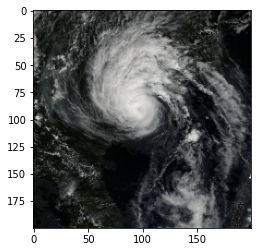

In [8]:
test = stage_3[0]
plt.imshow(test)

In [10]:
import albumentations as A
import cv2

transform = A.Compose([
    A.RandomCrop(width=200, height=200),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

transformed_img = transform(test)

ImportError: cannot import name 'Concatenate'

In [6]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    print(dims, dims[-3], dims[-2])
    x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [14]:
# float32 is a valid data type, convertable into Tensor object (for DeepLabV3+)

highest_wind = highest_wind.astype("int")

stage_1 = stage_1.astype("int")
stage_1 = np.swapaxes(stage_1, 1, 2)
stage_1 = np.swapaxes(stage_1, 2, 3)

stage_2 = stage_2.astype("int")
stage_2 = np.swapaxes(stage_2, 1, 2)
stage_2 = np.swapaxes(stage_2, 2, 3)

stage_3 = stage_3.astype("int")
stage_3 = np.swapaxes(stage_3, 1, 2)
stage_3 = np.swapaxes(stage_3, 2, 3)

print(stage_1.shape, stage_2.shape, stage_3.shape)

(117, 200, 200, 3) (117, 200, 200, 3) (117, 200, 200, 3)


In [15]:
# img


indices = np.arange(0, stage_1.shape[0], 1)
print(len(indices))
print(len(highest_wind))

index_train, index_test, y_train, y_test = train_test_split(
    indices, highest_wind, train_size = 0.8, random_state = 2309)

stage_1_train = None
stage_1_test = None

for i in index_train: # get shuffled training datasets
    if stage_1_train is None:
        stage_1_train = stage_1[i:i+1, :, :, :] # i:i+1 to force shape of a 4D tensor, doesn't change index values
        stage_2_train = stage_2[i:i+1, :, :, :]
        stage_3_train = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_train = np.append(stage_1_train, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_train = np.append(stage_2_train, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_train = np.append(stage_3_train, stage_3[i:i+1, :, :, :], axis = 0)

for i in index_test: # get shuffled testing datasets
    if stage_1_test is None:
        stage_1_test = stage_1[i:i+1, :, :, :]
        stage_2_test = stage_2[i:i+1, :, :, :]
        stage_3_test = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_test = np.append(stage_1_test, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_test = np.append(stage_2_test, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_test = np.append(stage_3_test, stage_3[i:i+1, :, :, :], axis = 0)

print(stage_1_train.shape, len(y_train))
print(stage_1_test.shape, len(y_test))

print(y_train, y_test)

print(index_train[0])

117
117
(93, 200, 200, 3) 93
(24, 200, 200, 3) 24
[135. 100. 130.  70.  70. 135.  70.  90. 155.  80.  95.  75.  65. 135.
  70. 115. 135. 125.  80.  75.  75. 120.  65.  90.  75.  70. 105.  65.
 100. 150.  70.  85. 125.  80. 110.  70. 100. 100.  80.  75.  75. 115.
 105. 145.  65.  65.  95.  90.  80. 120.  80. 155.  75.  65.  70. 110.
  80.  75.  95. 145. 130.  80. 120.  80. 120.  70.  70. 100.  85. 120.
 125. 120.  70.  75. 125.  75. 125.  90.  65. 125. 145. 125.  65. 115.
 160. 100.  65.  75.  80. 110.  70.  65.  65.] [ 90. 110. 100.  65. 105. 145. 100.  90.  85.  75.  85.  65.  70. 105.
  70. 125. 135.  75.  75.  65.  90. 125. 100. 110.]
116


In [16]:
stage_3_train = tf.convert_to_tensor(stage_3_train)
y_train = tf.convert_to_tensor(y_train)

stage_3_test = tf.convert_to_tensor(stage_3_test)
y_test = tf.convert_to_tensor(y_test)

In [17]:
def DeepLabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(200, 200, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=(model_input)
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = keras.layers.Concatenate(axis=-1)([input_a, 
                                           #input_b
                                          ])
    x = convolution_block(x)
    x = convolution_block(x)
    x = keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeepLabV3Plus(image_size=200, num_classes=3)
model.summary()

(None, 13, 13, 256) 13 13
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________

conv3_block1_1_bn (BatchNormali (None, 25, 25, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 25, 25, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 25, 25, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_bn (BatchNormali (None, 25, 25, 128)  512         conv3_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_relu (Activation (None, 25, 25, 128)  0           conv3_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_bloc

In [ ]:
'''
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

batch_size = 5
num_updates = int(len(stage_3_train) / batch_size)

print(len(stage_3_train), num_updates)

def step(X, y):
    # keep track of our gradients
    with tf.GradientTape() as tape:
        # make a prediction using the model and then calculate the
        # loss
        pred = model(X)
        loss = keras.losses.SparseCategoricalCrossentropy(y, pred)
        print("training loss:",loss)
    # calculate the gradients using our tape and then update the
    # model weights
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
'''
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(stage_3_train, validation_data=(stage_3_test, ), 
                    epochs=20)
                    '''

for epoch in range(0, 20):
    # show the current epoch number
    print("training epoch", epoch)
    # loop over the data in batch size increments
    for i in range(0, num_updates):
        # determine starting and ending slice indexes for the current
        # batch
        start = i * batch_size
        end = start + batch_size

        step(stage_3_train, y_train)
'''

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()